In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import glob
import skimage.io
import matplotlib
import skimage.transform as skt
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
import pickle 

CLUSTER_BASE = '/home/apoorvkul/clusters'

with open(os.path.join(CLUSTER_BASE, 'all_files.pk'), 'rb') as f:
    FILE_LIST = pickle.load(f)
    
FILE_LIST = [os.path.join(CLUSTER_BASE, f) for f in FILE_LIST]

In [3]:
class NucleiDataset(utils.Dataset):
    
    def prepare(self):
        self.name = "nuclei"
        self.add_class(self.name, 1, "nucleus")
        for i, basePath in enumerate(FILE_LIST):
            imgRef = os.path.basename(basePath)
            self.add_image(self.name, image_id=i, 
                           path=basePath+'.png',
                           maskPath=glob.glob(basePath + '/*.png'),
                           img_ref=imgRef)
        super().prepare()
        
    def load_image(self, image_id):
        image = skimage.io.imread(self.image_info[image_id]['path'])[:,:,:3]
        return image
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == self.name:
            return info['img_ref']
        else:
            return super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        masks = np.dstack([skimage.io.imread(f) for f in self.image_info[image_id]['maskPath']])
        return masks, np.repeat(1, masks.shape[-1])
    
def getDatasets(cvPart):
    dataset_train = NucleiDataset()
    dataset_train.prepare()

    dataset_val = NucleiDataset()
    dataset_val.prepare()
    return dataset_train, dataset_val

In [4]:
dataset_train, dataset_val =getDatasets(9)
len(dataset_train.image_info), len(dataset_val.image_info)

(1379, 1379)

In [12]:
class ACNDConfig(Config):
    NAME = 'ACND'
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False
    OPTIMIZER = 'SGD'
    STEPS_PER_EPOCH = 1379
    VALIDATION_STEPS = 100
    BACKBONE = "resnet50"
    
config = ACNDConfig()

import keras.backend

K = keras.backend.backend()
if K=='tensorflow':
    keras.backend.set_image_dim_ordering('tf')

## Ceate Model

In [13]:
import keras.backend

K = keras.backend.backend()
if K=='tensorflow':
    keras.backend.set_image_dim_ordering('tf')
    # Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [14]:
#utils.download_trained_weights(COCO_MODEL_PATH)

In [15]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    print(model.find_last()[1])

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
for i in range(0,10):
    model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=i+1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/apoorvkul/Project/Mask_RCNN/logs/acnd20180410T0852/mask_rcnn_acnd_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


/home/apoorvkul/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


1379/1379 [==============================] - 1147s 831ms/step - loss: 2.4133 - rpn_class_loss: 0.2651 - rpn_bbox_loss: 1.1561 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.4153 - mrcnn_mask_loss: 0.3729 - val_loss: 3.3833 - val_rpn_class_loss: 0.4006 - val_rpn_bbox_loss: 1.8062 - val_mrcnn_class_loss: 0.1059 - val_mrcnn_bbox_loss: 0.5628 - val_mrcnn_mask_loss: 0.5078

Starting at epoch 1. LR=0.001

Checkpoint Path: /home/apoorvkul/Project/Mask_RCNN/logs/acnd20180410T0852/mask_rcnn_acnd_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)

In [14]:
def cleanup():
    for f in sorted(glob.glob('/home/apoorvkul/Project/Mask_RCNN/logs/acnd*/mask_rcnn_acnd_*'))[:-1]:
        os.remove(f)

In [ ]:
for i in range(10):
    cleanup()
    nextEpoch = model.epoch + 1
    dataset_train, dataset_val = getDatasets(nextEpoch%10)
    model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=nextEpoch, 
            layers="all",
            recompile=(i==0))

In [ ]:
for i in range(10):
    cleanup()
    nextEpoch = model.epoch + 1
    dataset_train, dataset_val = getDatasets(nextEpoch%10)
    model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10,
            epochs=nextEpoch, 
            layers="all",
            recompile=(i==0))

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=109, 
            layers="all")

In [18]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ACNDConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model1 = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = os.path.join(ROOT_DIR, "logs/acnd20180408T1332/mask_rcnn_acnd_0008.h5")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model1.load_weights(model_path, by_name=True)

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
APs = []
for image_id in dataset_val.image_ids[:10]:
    
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model1.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
r['masks']

In [18]:
import pandas as pd
pd.Series(APs).describe()

count    67.000000
mean      0.767902
std       0.213285
min       0.160473
25%       0.684939
50%       0.816574
75%       0.914855
max       1.000000
dtype: float64

In [217]:
APs = []
for image_id in dataset_train.image_ids:
    
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model1.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP:  0.791821913844


In [218]:
pd.Series(APs).describe()

count    600.000000
mean       0.791822
std        0.192148
min        0.000000
25%        0.701943
50%        0.823529
75%        0.944444
max        1.000000
dtype: float64

In [8]:
class TestNucleiDataset(utils.Dataset):
    image_path_pat = '/home/apoorvkul/Project/stage1_test/*/'
    
    def prepare(self, cvPart, validation=False):
        self.name = "nuclei"
        self.add_class(self.name, 1, "nucleus")
        pathList = sorted(glob.glob(self.image_path_pat))
        for i, basePath in enumerate(pathList):
            self.add_image(self.name, image_id=i, 
                           path=glob.glob(basePath + 'images/*.png')[0],
                           maskPath=glob.glob(basePath + 'masks/*.png'))
        super().prepare()

        
    def load_image(self, image_id):
        image = skimage.io.imread(self.image_info[image_id]['path'])[:,:,:3]
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == self.name:
            return os.path.splitext(os.path.basename(info['path']))[0]
        else:
            return super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        return np.empty((256,256, 0)), np.array([])

dataset_test = TestNucleiDataset()
dataset_test.prepare(9)
len(dataset_test.image_info)

65

In [19]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    # We need to allow for cases where there is a '1' at either end of the sequence.
    # We do this by padding with a zero at each end when needed.
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return ' '.join(str(x) for x in rle)

def cleanMasks(masks):
    removed = set()
    cleaned = []
    masks = masks[:,:,np.sum(masks, (0,1)).argsort()]
    numMask = masks.shape[-1]
    for i in range(numMask):
        if i not in removed:
            cleaned.append(masks[:,:,i])
            for j in range(numMask):
                if i < j:
                    intersection = masks[:,:,i]&masks[:,:,j] 
                    if np.any(intersection > 0):
                        commonArea = intersection.sum()
                        areaRatioI= commonArea/masks[:,:,i].sum()
                        areaRatioJ= commonArea/masks[:,:,j].sum()
                        if  areaRatioJ > 0.8:
                            cleaned[-1] = cleaned[-1]|masks[:,:,j]
                            removed.add(j)
                        elif areaRatioI > 0.8:
                            masks[:,:,j] = cleaned[-1]|masks[:,:,j]
                            del cleaned[-1]
                            break
                        elif areaRatioI > areaRatioJ:
                            masks[:,:,j] = masks[:,:,j]-intersection
                        else:
                            cleaned[-1] = cleaned[-1]-intersection
    return cleaned

In [21]:
with open('/home/apoorvkul/Project/Mask_RCNN/logs/res.txt', 'w') as f:
    f.write('ImageId,EncodedPixels\n')
    for image_id in dataset_test.image_ids:
            
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id, use_mini_mask=False)
        #molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model1.detect([image], verbose=0)
        r = results[0]
        line_head = dataset_test.image_reference(image_id) + ","
        masks = cleanMasks(r['masks'])
        summedMask = np.sum(np.dstack(masks), -1)
        if np.any(summedMask>1):
            print("failed")
            break
        f.write('\n'.join(line_head + rle_encode(m) for m in masks))
        f.write('\n')

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


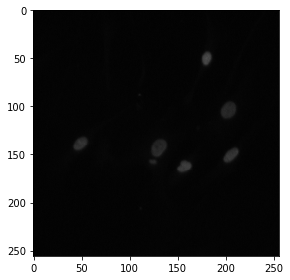

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


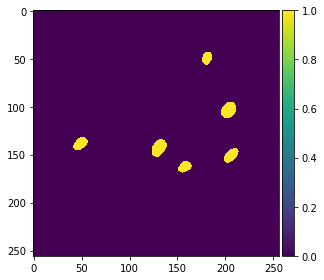

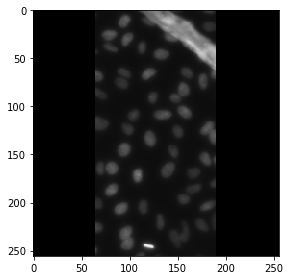

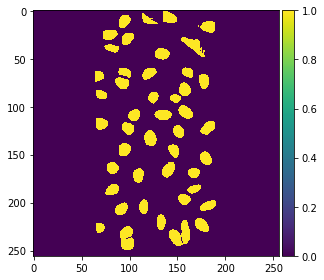

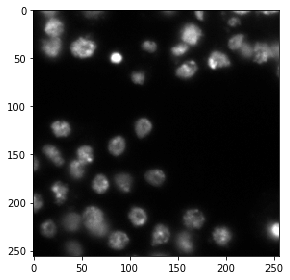

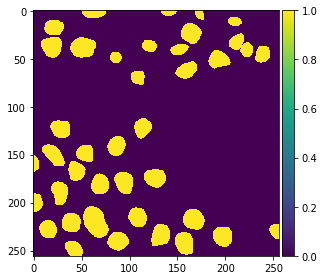

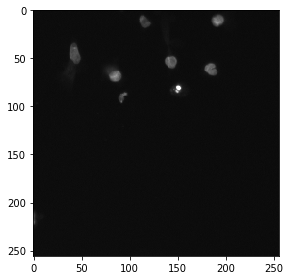

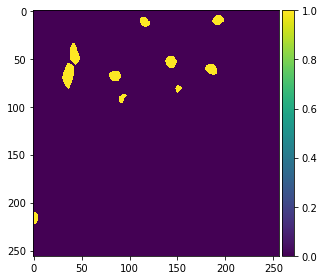

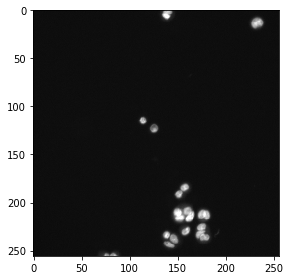

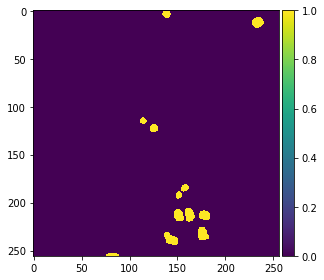

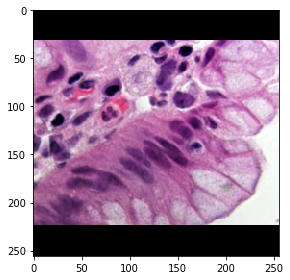

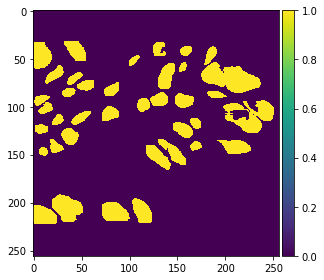

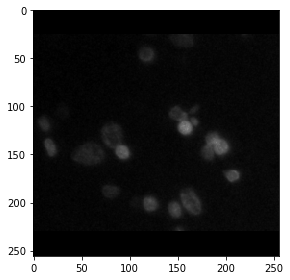

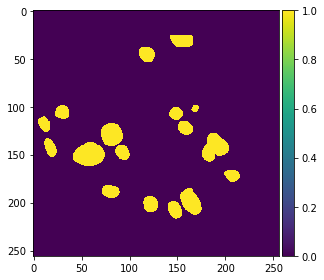

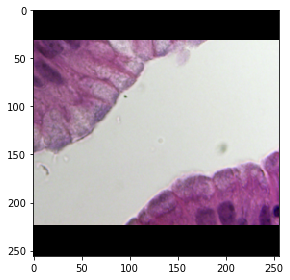

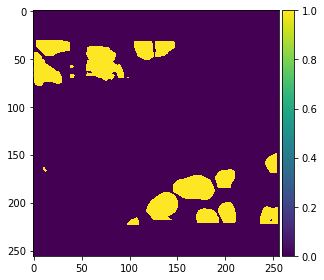

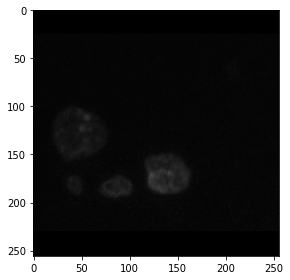

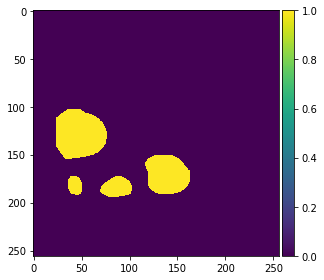

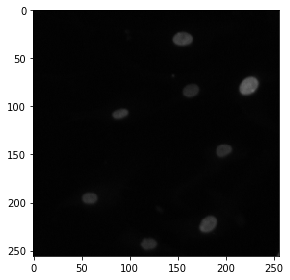

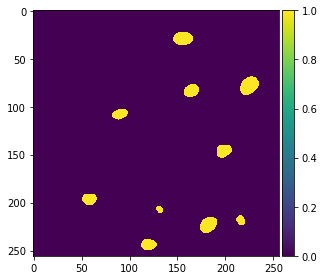

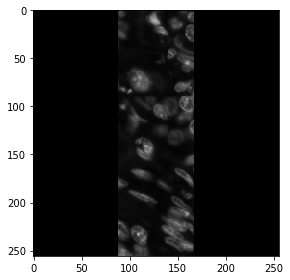

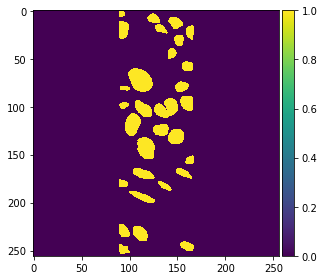

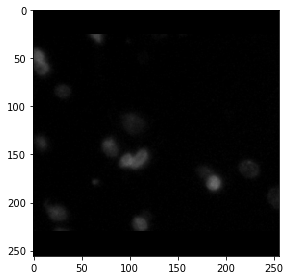

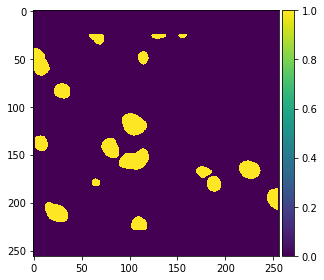

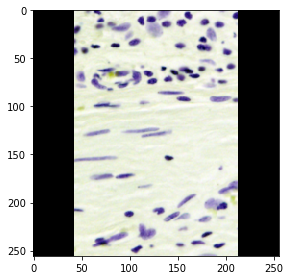

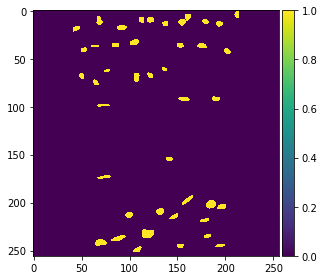

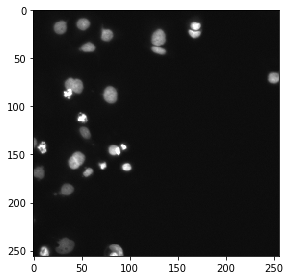

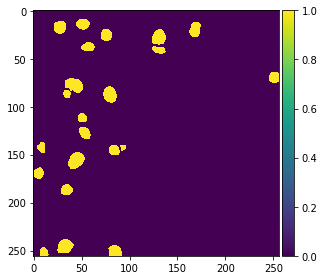

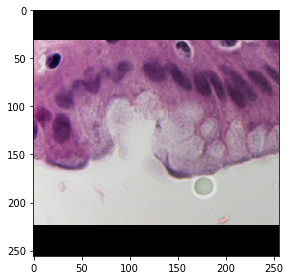

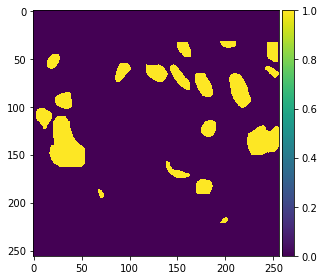

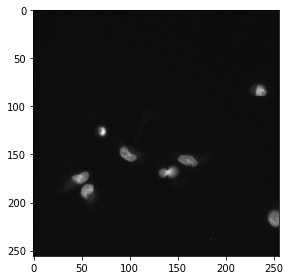

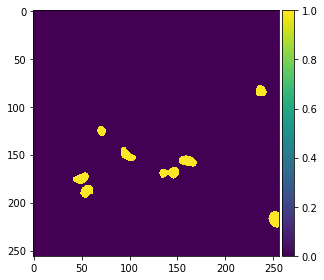

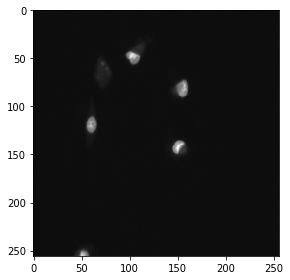

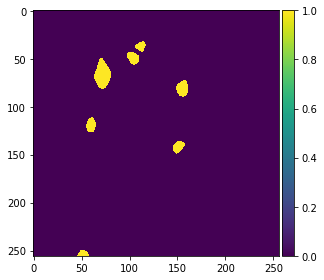

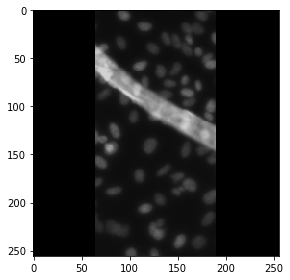

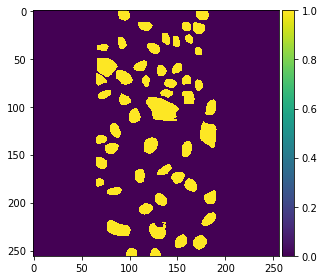

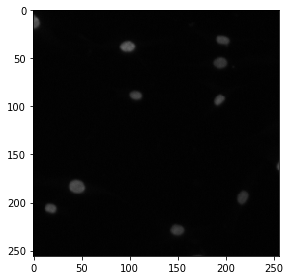

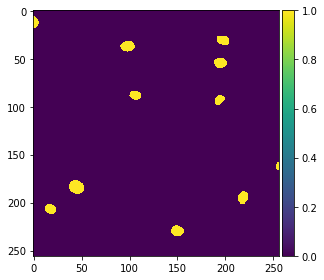

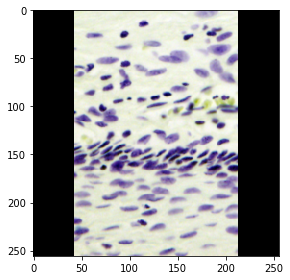

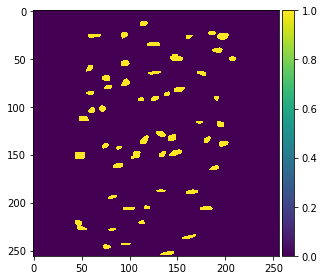

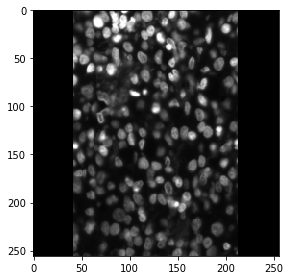

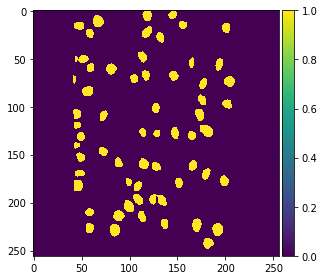

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


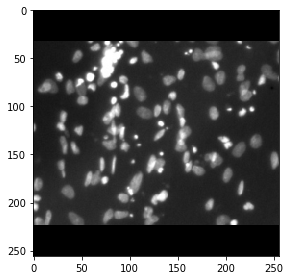

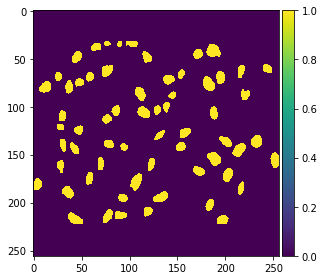

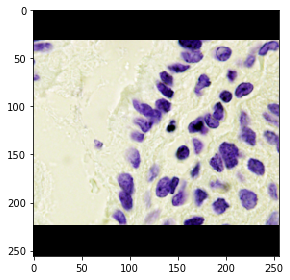

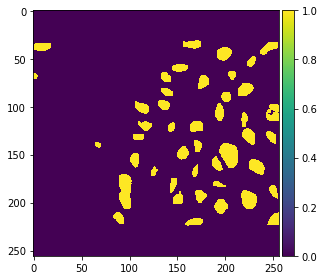

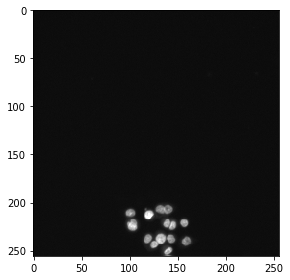

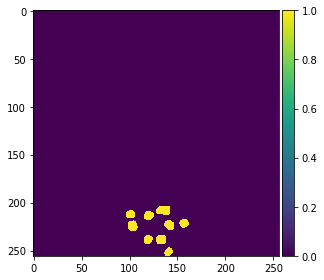

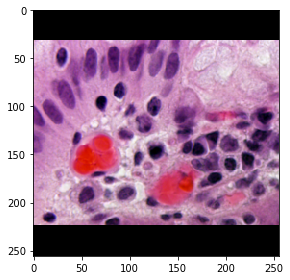

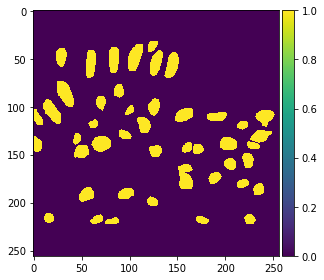

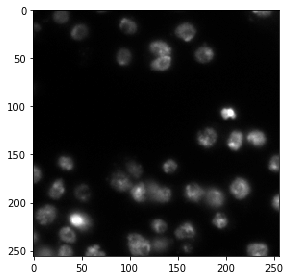

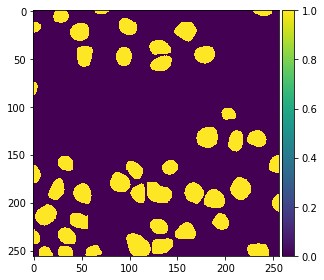

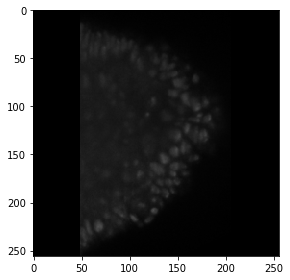

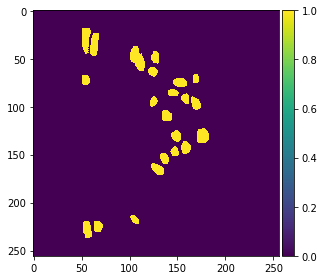

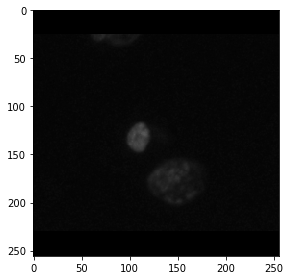

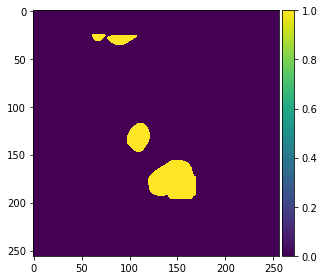

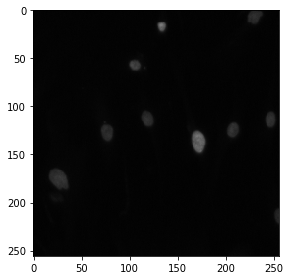

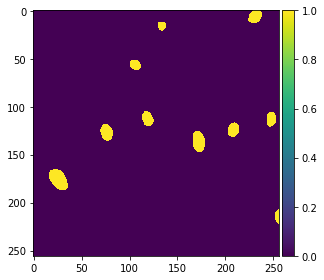

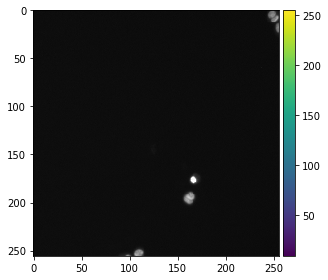

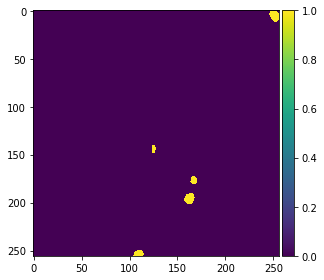

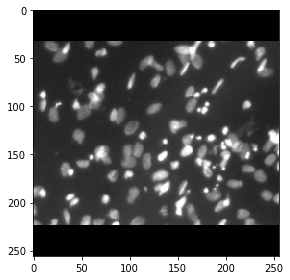

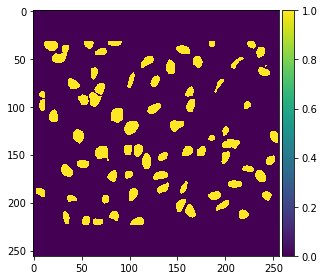

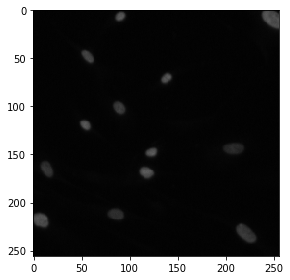

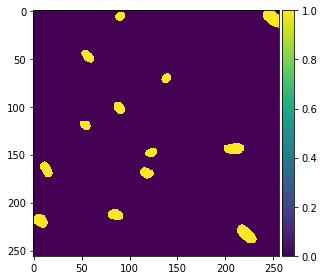

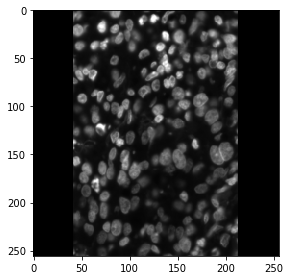

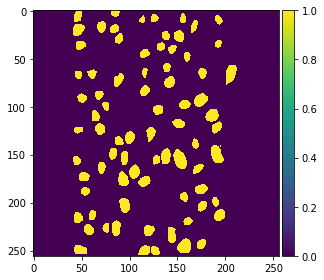

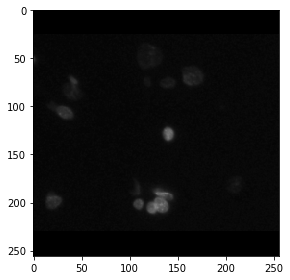

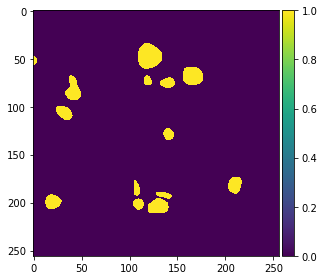

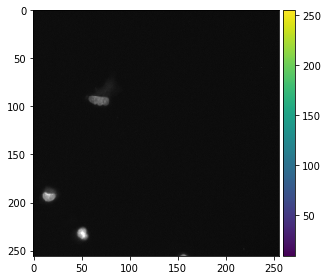

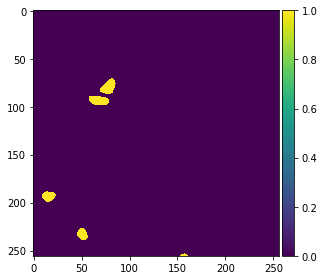

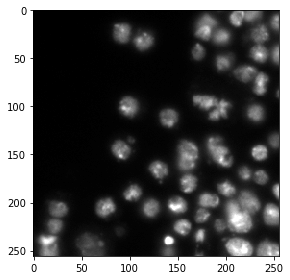

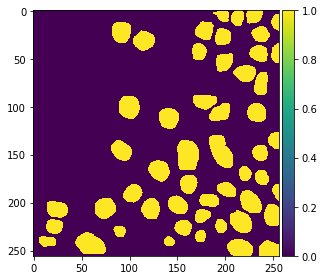

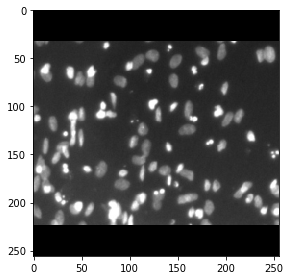

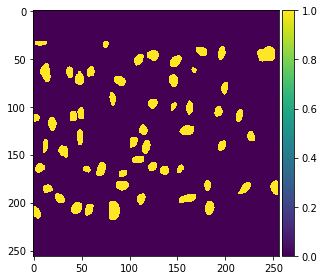

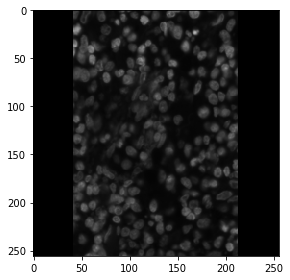

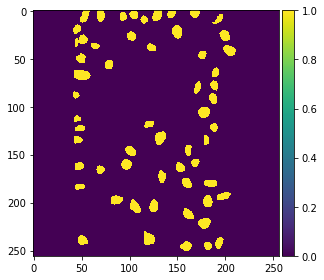

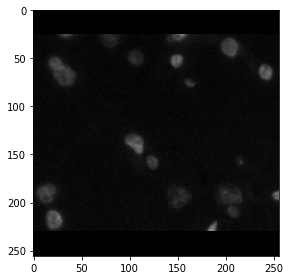

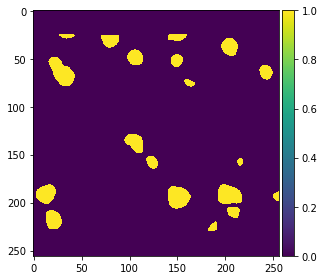

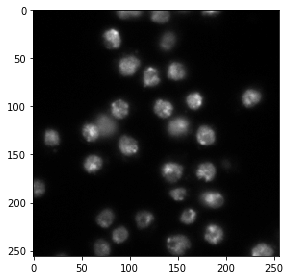

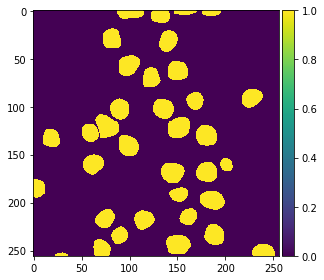

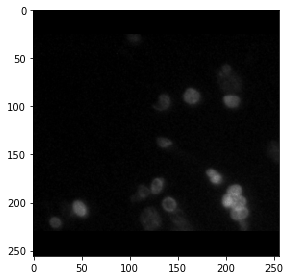

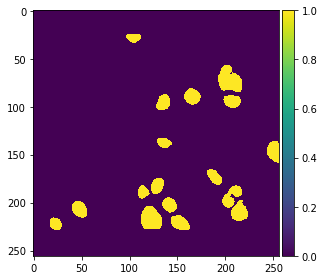

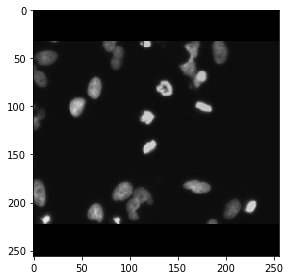

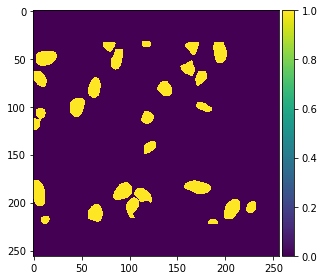

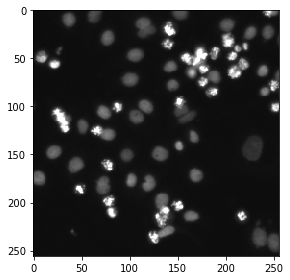

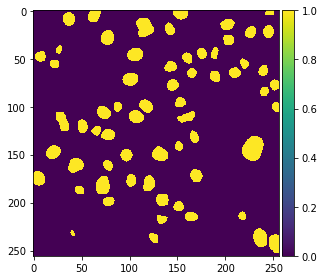

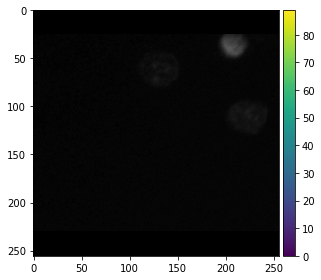

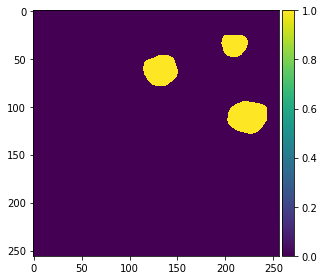

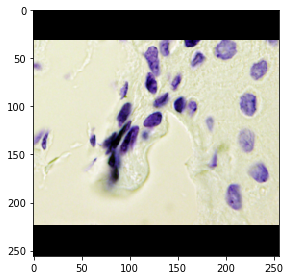

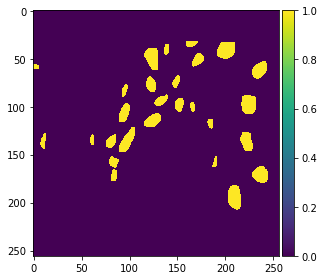

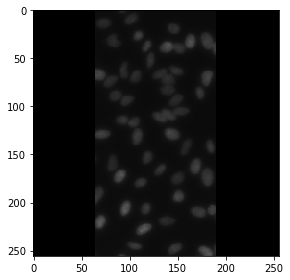

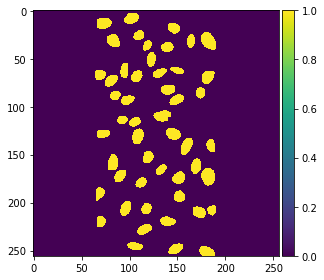

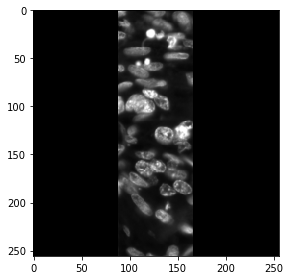

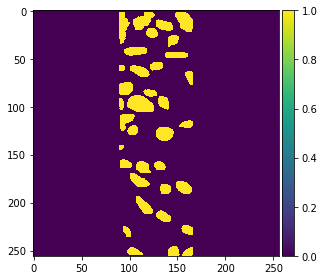

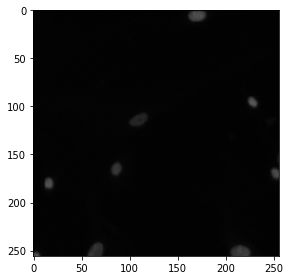

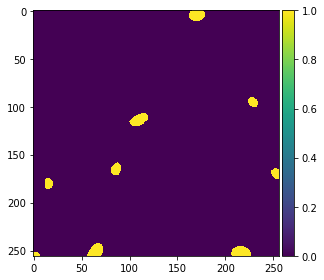

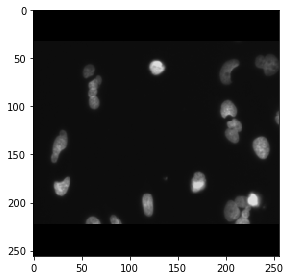

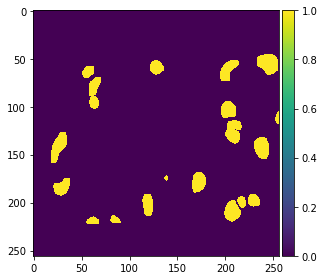

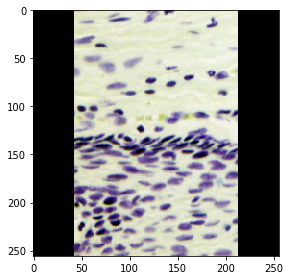

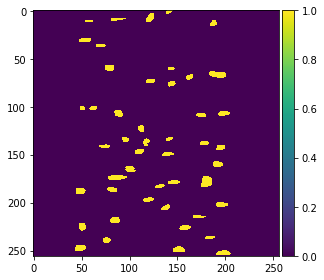

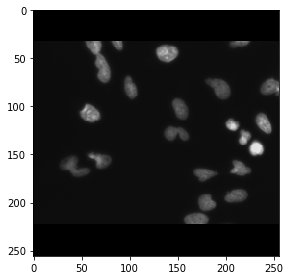

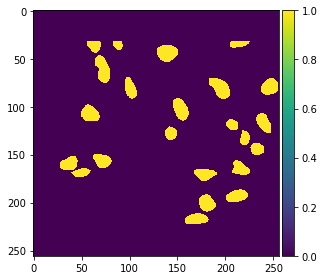

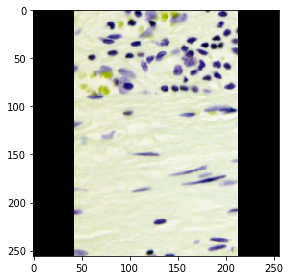

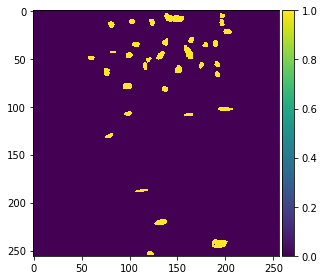

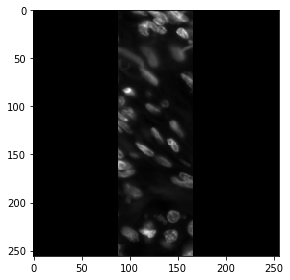

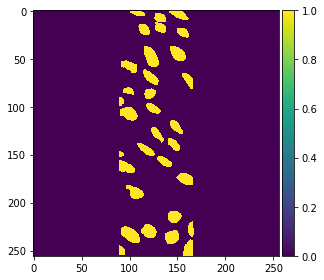

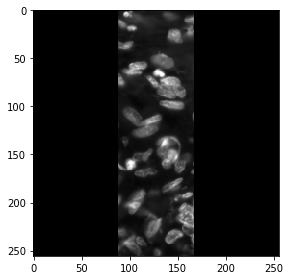

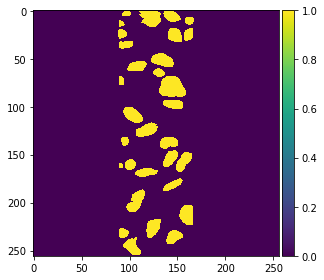

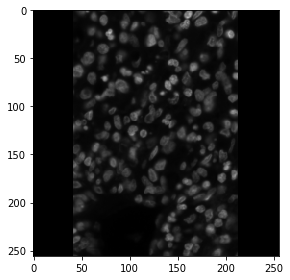

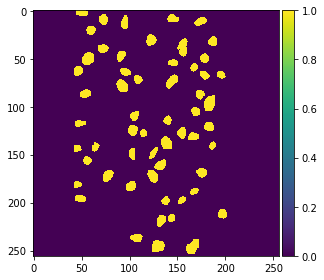

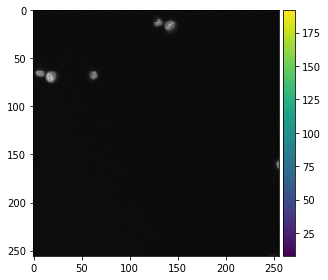

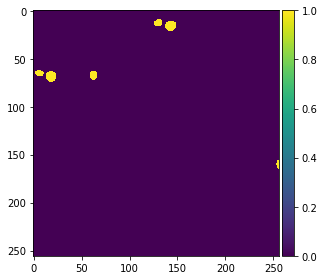

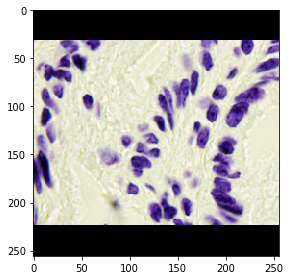

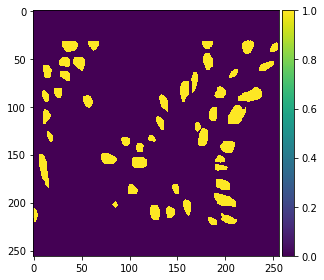

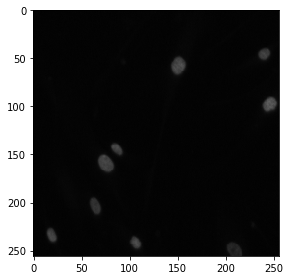

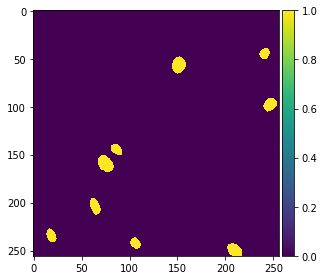

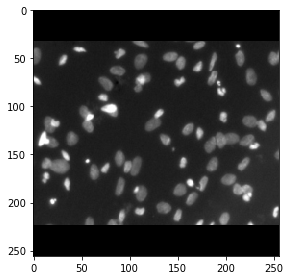

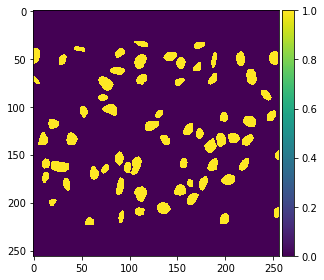

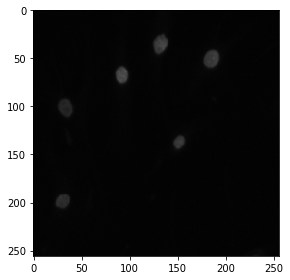

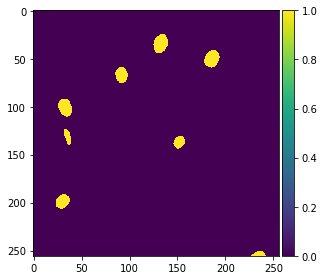

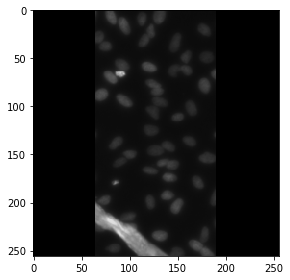

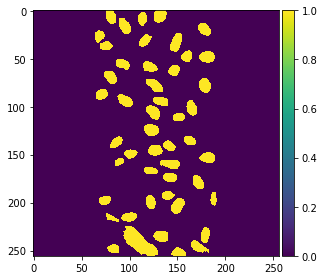

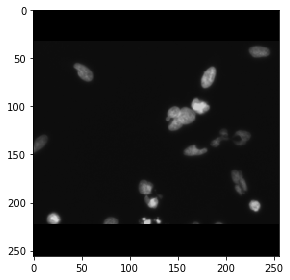

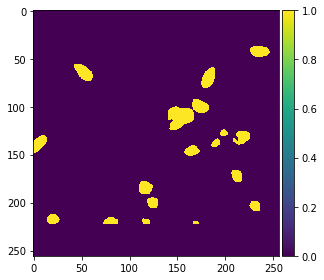

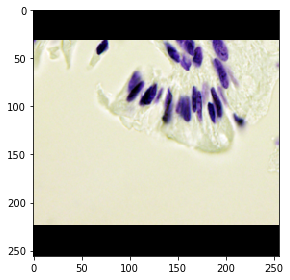

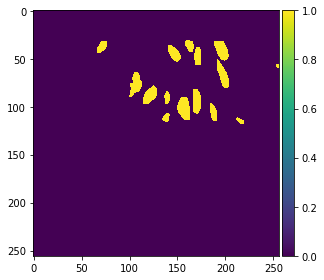

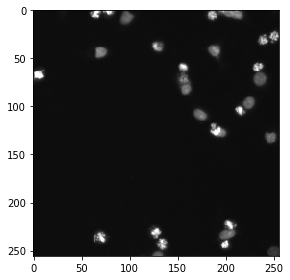

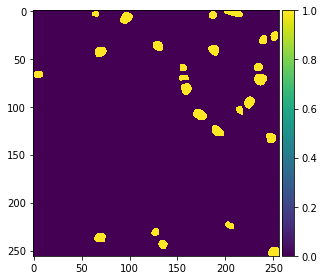

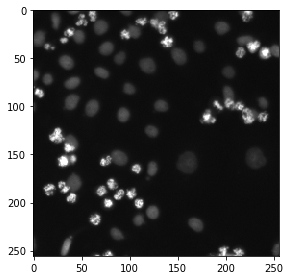

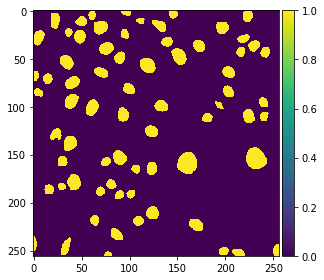

In [23]:
for image_id in dataset_test.image_ids:

    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    #molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model1.detect([image], verbose=0)
    r = results[0]
    line_head = dataset_test.image_reference(image_id) + ","
    masks = cleanMasks(r['masks'])
    summedMask = np.sum(np.dstack(masks), -1)

    skimage.io.imshow(image)
    skimage.io.show()
    skimage.io.imshow(summedMask)
    skimage.io.show()
    

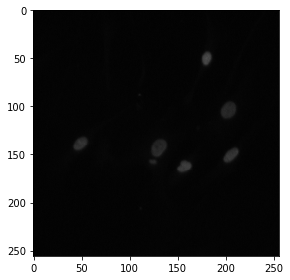

In [90]:
skimage.io.imshow(image)

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


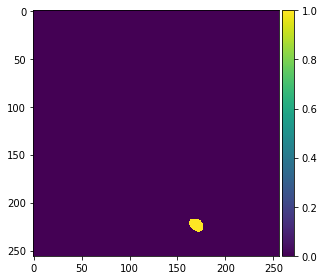

In [210]:
skimage.io.imshow(r['masks'][:,:,0])

In [162]:
np.sum(r['masks'], -1).shape

(256, 256)

In [175]:
[i for i in range(r['masks'].shape[-1]) if mc.clean(r['masks'][:,:,i])]

[59, 61, 64, 65, 69, 74]

In [205]:
resMask = cleanMasks(r['masks'])

/home/apoorvkul/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


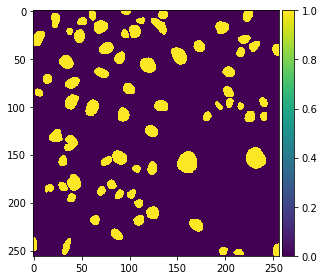

In [215]:
skimage.io.imshow(np.sum(np.dstack(masks), -1))

In [18]:
r['masks']

array([], shape=(0, 28, 28), dtype=float64)